# Creating dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
DATADIR = '../datasets/Classification/Dataset - 7 dias/Images'
CATEGORIES = ["Normal", "Anormal", "Morta"]

In [3]:
def create_training_data():
    training_data = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
            ## add images to training data with its label
            training_data.append([img_array, class_num])
    return training_data
            
training_data = create_training_data()

In [4]:
print(len(training_data))

1185


In [5]:
#mix data for better learning
import random
random.shuffle(training_data)

In [6]:
images = []
labels = []

for image, label in training_data:
    images.append(image)
    labels.append(label)

In [7]:
##saving dataset
import pickle
DATASET_PATH = "../datasets/Classification/Dataset - 7 dias/"

pickle_out = open(os.path.join(DATASET_PATH, "7_days_images.pickle"), "wb")
pickle.dump(images, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(DATASET_PATH, "7_days_labels.pickle"), "wb")
pickle.dump(labels, pickle_out)
pickle_out.close()



# Creating classification model
##### Following this tutorial
       www.youtube.com/watch?v=WvoLTXIjBYU
##### Characteristics
 - Sequencial Model
 - Fully trained on this dataset

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import keras
import os


#### Reading and preparing the dataset

In [9]:
import imutils
def pad_image(image, size_x, size_y):
    shape = image.shape
    res = []
    
    pad_image = np.zeros((size_x,size_y,3), np.uint8)
    
    if shape[0] > shape[1]:
        res = imutils.resize(image, height=size_x)
        res = center_image(res, pad_image)
    else:
        res = imutils.resize(image, width=size_y)
        res = center_image(res, pad_image)
    
    return res
    
def center_image(image, background):
    img_shape = image.shape
    bck_shape = background.shape
    
    x_diff = round((bck_shape[0] - img_shape[0])/2)
    y_diff = round((bck_shape[1] - img_shape[1])/2)
    
#     print(image.shape, background.shape, x_diff, y_diff)
    
    res = background.copy()
    
    res[x_diff:x_diff + img_shape[0],y_diff:y_diff + img_shape[1]] = image
    
    return res
        

In [10]:
images_raw = open(os.path.join(DATASET_PATH, "7_days_images.pickle" ), "rb")
images = pickle.load(images_raw)

labels_raw = open(os.path.join(DATASET_PATH, "7_days_labels.pickle" ), "rb")
labels = pickle.load(labels_raw)

#reshape images
IMG_SIZE = 512

##### Padding Images in Memory

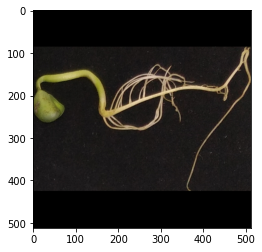

In [11]:
for i in range(len(images)):
    images[i] = pad_image(images[i], IMG_SIZE, IMG_SIZE)
    plt.imshow(images[i])

##### Labels one hot enconding

###### Train Test split

In [12]:
images = np.array(images)

from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2)

In [13]:
print(train_images.shape[0] + test_images.shape[0])

1185


#### Ajustando o dataset desbalanceado

###### Data augmentation -> data generator

In [14]:
# data augmentation with ImageDataGenerator -> did not go well
# from keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=False,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.25
# )
# datagen.fit(train_images)

# # it = datagen.flow(train_images, batch_size=1, save_to_dir="test", shuffle= True)

# # # generate samples and plot
# # for i in range(50):
# #      # generate batch of images
# #     batch = it.next()
# #     # convert to unsigned integers for viewing
# #     image = batch[0].astype('uint8')
# #     # plot raw pixel data
# #     plt.imshow(image, cmap="gray")
# #     plt.show()
# # show the figure

###### Weighted Classes 

In [15]:
## Trying class weights
#it does not work withone hot encoded data
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(train_labels),
#                                                  train_labels)

# from sklearn.utils import compute_sample_weight
# sample_weights = compute_sample_weight('balanced', train_labels)  #->>>> remember to add the weights in model.fit


###### SMOTE

In [16]:
# classes, counts = np.unique(train_labels, return_counts=True)
# print(f"The number of elements for each class in training now are\nClass 0: {counts[0]}\nClass 1 {counts[1]}\nClass 2 {counts[2]}\n")

In [17]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)

# train_images_shape = train_images.shape
# train_images = train_images.reshape((train_images_shape[0], IMG_SIZE * IMG_SIZE * 3))
# train_images, train_labels = sm.fit_resample(train_images, train_labels)


In [18]:
# train_images_shape = train_images.shape
# train_images = train_images.reshape((train_images_shape[0], IMG_SIZE, IMG_SIZE, 3))


In [19]:
# classes, counts = np.unique(train_labels, return_counts=True)
# print(f"The number of elements for each class in training now are\nClass 0: {counts[0]}\nClass 1 {counts[1]}\nClass 2 {counts[2]}\n")

##### One hot label encoding

In [20]:
import pandas as pd

train_labels = pd.get_dummies(train_labels)
train_labels = pd.DataFrame.to_numpy(train_labels)

test_labels_1d = test_labels

test_labels = pd.get_dummies(test_labels)
test_labels = pd.DataFrame.to_numpy(test_labels)

##### Normalizing training images

In [21]:
# train_images = tf.keras.utils.normalize(train_images, axis=0, order=2)

### Creating the model


In [22]:
EPOCHS = 50
TRAIN_TEST_SPLIT = 0.25
BATCH_SIZE = 32
# print((1 - TRAIN_TEST_SPLIT) * train_images.shape[0],BATCH_SIZE)

In [30]:
def create_model( layer_filters_num=2, layer_filters_sizes=(2,2), dropout_rate=0.3,  dense_size=2, optmizer=0, lr=0.00001):
    
    my_metrics = ["accuracy",
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.AUC(),
           tf.keras.metrics.TruePositives(),
           tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.FalsePositives(),
           tf.keras.metrics.FalseNegatives(),]
    
    model = Sequential()

    model.add(   Conv2D(layer_filters_num, layer_filters_sizes, input_shape=train_images.shape[1:])  )
    model.add(Activation("relu"))
    model.add(Dropout(dropout_rate, input_shape=images.shape[1:]))
    model.add(MaxPooling2D(pool_size= (2,2)))

    model.add(Flatten())
    model.add(Dense(dense_size))
    
    model.add(Dense(3))
    model.add(Activation("softmax"))

    opt = [keras.optimizers.Adam(learning_rate=lr) , keras.optimizers.RMSprop(learning_rate=lr) , tf.keras.optimizers.Adamax(learning_rate=lr), tf.keras.optimizers.SGD(learning_rate=lr)]
    
    model.compile(loss="categorical_crossentropy", optimizer=opt[optmizer], metrics=my_metrics)
    
    return model

from keras.wrappers.scikit_learn import KerasClassifier
estimator = KerasClassifier(build_fn=create_model, verbose=1)

param_grid = {
    'layer_filters_num': [ 1, 3 ],
    'layer_filters_sizes': [ (1,1), (2,2) ],
    'dropout_rate': [ 0.5, 0.1, 0 ],
    'dense_size': [ 1, 5, 10, 25 ], 
    'optmizer':[0, 1],
    'lr':[0.00001, 0.0001],
}

from sklearn.model_selection import GridSearchCV
X = train_images
y = train_labels
kfold_splits = 2
grid = GridSearchCV(estimator=estimator,  
                    n_jobs=1, 
                    verbose=10,
                    return_train_score=True,
                    cv=kfold_splits,  #StratifiedKFold(n_splits=kfold_splits, shuffle=True)
                    param_grid=param_grid,)

In [31]:
grid_result = grid.fit(X, y, ) #callbacks=[tbCallBack]

Fitting 2 folds for each of 192 candidates, totalling 384 fits
[CV 1/2; 1/192] START dense_size=1, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0
15/15 [==============================] - 1s 65ms/step - loss: 1.0977 - accuracy: 0.3333 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - auc_4: 0.5304 - true_positives_4: 0.0000e+00 - true_negatives_4: 948.0000 - false_positives_4: 0.0000e+00 - false_negatives_4: 474.0000
[CV 1/2; 1/192] END dense_size=1, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0; total time=  11.4s
[CV 2/2; 1/192] START dense_size=1, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0
15/15 [==============================] - 1s 67ms/step - loss: 1.0984 - accuracy: 0.8143 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - auc_5: 0.5000 - true_positives_5: 0.0000e+00 - true_negatives_5: 948.0000 - false_positives_5: 0.0000e+00 - false_negatives_5: 474.00

15/15 [==============================] - 1s 59ms/step - loss: 1.0052 - accuracy: 0.8165 - precision_11: 0.6471 - recall_11: 0.0232 - auc_11: 0.8812 - true_positives_11: 11.0000 - true_negatives_11: 942.0000 - false_positives_11: 6.0000 - false_negatives_11: 463.0000
[CV 2/2; 4/192] END dense_size=1, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1; total time=   7.9s
[CV 1/2; 5/192] START dense_size=1, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=0
15/15 [==============================] - 3s 214ms/step - loss: 1.4594 - accuracy: 0.1181 - precision_12: 0.1014 - recall_12: 0.0612 - auc_12: 0.4234 - true_positives_12: 29.0000 - true_negatives_12: 691.0000 - false_positives_12: 257.0000 - false_negatives_12: 445.0000
[CV 1/2; 5/192] END dense_size=1, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=0; total time=  11.8s
[CV 2/2; 5/192] START dense_size=1, dropout_rate=0.5, 

15/15 [==============================] - 3s 212ms/step - loss: 0.7905 - accuracy: 0.8228 - precision_19: 0.8392 - recall_19: 0.8038 - auc_19: 0.9342 - true_positives_19: 381.0000 - true_negatives_19: 875.0000 - false_positives_19: 73.0000 - false_negatives_19: 93.0000
[CV 2/2; 8/192] END dense_size=1, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=1; total time=  13.2s
[CV 1/2; 9/192] START dense_size=1, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0
15/15 [==============================] - 1s 76ms/step - loss: 4.4482 - accuracy: 0.6646 - precision_20: 0.6797 - recall_20: 0.6582 - auc_20: 0.7912 - true_positives_20: 312.0000 - true_negatives_20: 801.0000 - false_positives_20: 147.0000 - false_negatives_20: 162.0000
[CV 1/2; 9/192] END dense_size=1, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0; total time=   9.8s
[CV 2/2; 9/192] START dense_size=1, dropout_rate=0.5

15/15 [==============================] - 1s 77ms/step - loss: 7.2044 - accuracy: 0.7848 - precision_26: 0.7848 - recall_26: 0.7848 - auc_26: 0.8403 - true_positives_26: 372.0000 - true_negatives_26: 846.0000 - false_positives_26: 102.0000 - false_negatives_26: 102.0000
[CV 1/2; 12/192] END dense_size=1, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1; total time=   9.3s
[CV 2/2; 12/192] START dense_size=1, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1
15/15 [==============================] - 1s 79ms/step - loss: 86.6273 - accuracy: 0.1540 - precision_27: 0.1540 - recall_27: 0.1540 - auc_27: 0.3655 - true_positives_27: 73.0000 - true_negatives_27: 547.0000 - false_positives_27: 401.0000 - false_negatives_27: 401.0000
[CV 2/2; 12/192] END dense_size=1, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1; total time=  10.0s
[CV 1/2; 13/192] START dense_size=1, dropout_r

15/15 [==============================] - 3s 221ms/step - loss: 67.0747 - accuracy: 0.6160 - precision_34: 0.6186 - recall_34: 0.6160 - auc_34: 0.7165 - true_positives_34: 292.0000 - true_negatives_34: 768.0000 - false_positives_34: 180.0000 - false_negatives_34: 182.0000
[CV 1/2; 16/192] END dense_size=1, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=1; total time=  14.0s
[CV 2/2; 16/192] START dense_size=1, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=1
15/15 [==============================] - 3s 192ms/step - loss: 54.0886 - accuracy: 0.8966 - precision_35: 0.8966 - recall_35: 0.8966 - auc_35: 0.9250 - true_positives_35: 425.0000 - true_negatives_35: 899.0000 - false_positives_35: 49.0000 - false_negatives_35: 49.0000
[CV 2/2; 16/192] END dense_size=1, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=1; total time=  14.9s
[CV 1/2; 17/192] START dense_size=1, dropout

15/15 [==============================] - 1s 61ms/step - loss: 2.4037 - accuracy: 0.1582 - precision_41: 0.1620 - recall_41: 0.1582 - auc_41: 0.5898 - true_positives_41: 75.0000 - true_negatives_41: 560.0000 - false_positives_41: 388.0000 - false_negatives_41: 399.0000
[CV 2/2; 19/192] END dense_size=1, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=0; total time=   7.8s
[CV 1/2; 20/192] START dense_size=1, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1
15/15 [==============================] - 1s 64ms/step - loss: 0.3844 - accuracy: 0.8038 - precision_42: 0.9467 - recall_42: 0.7489 - auc_42: 0.9656 - true_positives_42: 355.0000 - true_negatives_42: 928.0000 - false_positives_42: 20.0000 - false_negatives_42: 119.0000
[CV 1/2; 20/192] END dense_size=1, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1; total time=   6.6s
[CV 2/2; 20/192] START dense_size=1, dropout_rat

15/15 [==============================] - 3s 182ms/step - loss: 40.8699 - accuracy: 0.8101 - precision_49: 0.8101 - recall_49: 0.8101 - auc_49: 0.8581 - true_positives_49: 384.0000 - true_negatives_49: 858.0000 - false_positives_49: 90.0000 - false_negatives_49: 90.0000
[CV 2/2; 23/192] END dense_size=1, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0; total time=  12.3s
[CV 1/2; 24/192] START dense_size=1, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=1
15/15 [==============================] - 3s 180ms/step - loss: 10.1257 - accuracy: 0.4430 - precision_50: 0.4346 - recall_50: 0.4135 - auc_50: 0.5233 - true_positives_50: 196.0000 - true_negatives_50: 693.0000 - false_positives_50: 255.0000 - false_negatives_50: 278.0000
[CV 1/2; 24/192] END dense_size=1, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=1; total time=  11.1s
[CV 2/2; 24/192] START dense_size=1, dropout

15/15 [==============================] - 1s 88ms/step - loss: 5.5377 - accuracy: 0.7658 - precision_56: 0.7643 - recall_56: 0.7595 - auc_56: 0.8267 - true_positives_56: 360.0000 - true_negatives_56: 837.0000 - false_positives_56: 111.0000 - false_negatives_56: 114.0000
[CV 1/2; 27/192] END dense_size=1, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=0; total time=  10.1s
[CV 2/2; 27/192] START dense_size=1, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=0
15/15 [==============================] - 1s 71ms/step - loss: 34.6399 - accuracy: 0.7173 - precision_57: 0.7173 - recall_57: 0.7173 - auc_57: 0.7873 - true_positives_57: 340.0000 - true_negatives_57: 814.0000 - false_positives_57: 134.0000 - false_negatives_57: 134.0000
[CV 2/2; 27/192] END dense_size=1, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=0; total time=  12.1s
[CV 1/2; 28/192] START dense_size=1, dropout_

15/15 [==============================] - 4s 231ms/step - loss: 188.2874 - accuracy: 0.5781 - precision_64: 0.5781 - recall_64: 0.5781 - auc_64: 0.6779 - true_positives_64: 274.0000 - true_negatives_64: 748.0000 - false_positives_64: 200.0000 - false_negatives_64: 200.0000
[CV 1/2; 31/192] END dense_size=1, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0; total time=  15.0s
[CV 2/2; 31/192] START dense_size=1, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0
15/15 [==============================] - 4s 231ms/step - loss: 0.7071 - accuracy: 0.8080 - precision_65: 0.9085 - recall_65: 0.5443 - auc_65: 0.9294 - true_positives_65: 258.0000 - true_negatives_65: 922.0000 - false_positives_65: 26.0000 - false_negatives_65: 216.0000
[CV 2/2; 31/192] END dense_size=1, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0; total time=  15.9s
[CV 1/2; 32/192] START dense_size=1, dropou

15/15 [==============================] - 1s 67ms/step - loss: 3.4896 - accuracy: 0.7236 - precision_71: 0.7275 - recall_71: 0.7152 - auc_71: 0.7850 - true_positives_71: 339.0000 - true_negatives_71: 821.0000 - false_positives_71: 127.0000 - false_negatives_71: 135.0000
[CV 2/2; 34/192] END dense_size=1, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1; total time=   8.8s
[CV 1/2; 35/192] START dense_size=1, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=0
15/15 [==============================] - 1s 61ms/step - loss: 10.2857 - accuracy: 0.1730 - precision_72: 0.1786 - recall_72: 0.1730 - auc_72: 0.4841 - true_positives_72: 82.0000 - true_negatives_72: 571.0000 - false_positives_72: 377.0000 - false_negatives_72: 392.0000
[CV 1/2; 35/192] END dense_size=1, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=0; total time=   7.5s
[CV 2/2; 35/192] START dense_size=1, dropout_rate=0, 

15/15 [==============================] - 3s 211ms/step - loss: 44.5766 - accuracy: 0.5464 - precision_79: 0.5499 - recall_79: 0.5464 - auc_79: 0.6578 - true_positives_79: 259.0000 - true_negatives_79: 736.0000 - false_positives_79: 212.0000 - false_negatives_79: 215.0000
[CV 2/2; 38/192] END dense_size=1, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=1; total time=  13.3s
[CV 1/2; 39/192] START dense_size=1, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0
15/15 [==============================] - 4s 232ms/step - loss: 17.0313 - accuracy: 0.7131 - precision_80: 0.7161 - recall_80: 0.7131 - auc_80: 0.7839 - true_positives_80: 338.0000 - true_negatives_80: 814.0000 - false_positives_80: 134.0000 - false_negatives_80: 136.0000
[CV 1/2; 39/192] END dense_size=1, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0; total time=  14.1s
[CV 2/2; 39/192] START dense_size=1, dropout_rate

15/15 [==============================] - 2s 97ms/step - loss: 1.1164 - accuracy: 0.5316 - precision_86: 0.6400 - recall_86: 0.1350 - auc_86: 0.5955 - true_positives_86: 64.0000 - true_negatives_86: 912.0000 - false_positives_86: 36.0000 - false_negatives_86: 410.0000
[CV 1/2; 42/192] END dense_size=1, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1; total time=  10.4s
[CV 2/2; 42/192] START dense_size=1, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1
15/15 [==============================] - 1s 85ms/step - loss: 7.3341 - accuracy: 0.1266 - precision_87: 0.1269 - recall_87: 0.1224 - auc_87: 0.5049 - true_positives_87: 58.0000 - true_negatives_87: 549.0000 - false_positives_87: 399.0000 - false_negatives_87: 416.0000
[CV 2/2; 42/192] END dense_size=1, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1; total time=  10.8s
[CV 1/2; 43/192] START dense_size=1, dropout_rate=0, layer

15/15 [==============================] - 3s 228ms/step - loss: 6.4432 - accuracy: 0.8038 - precision_94: 0.8047 - recall_94: 0.7996 - auc_94: 0.8692 - true_positives_94: 379.0000 - true_negatives_94: 856.0000 - false_positives_94: 92.0000 - false_negatives_94: 95.0000
[CV 1/2; 46/192] END dense_size=1, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=1; total time=  15.2s
[CV 2/2; 46/192] START dense_size=1, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=1
15/15 [==============================] - 3s 213ms/step - loss: 1.0956 - accuracy: 0.6245 - precision_95: 0.0000e+00 - recall_95: 0.0000e+00 - auc_95: 0.5334 - true_positives_95: 0.0000e+00 - true_negatives_95: 948.0000 - false_positives_95: 0.0000e+00 - false_negatives_95: 474.0000
[CV 2/2; 46/192] END dense_size=1, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=1; total time=  15.7s
[CV 1/2; 47/192] START dense_size=1, dropou

15/15 [==============================] - 1s 67ms/step - loss: 1.0982 - accuracy: 0.8143 - precision_101: 0.0000e+00 - recall_101: 0.0000e+00 - auc_101: 0.5000 - true_positives_101: 0.0000e+00 - true_negatives_101: 948.0000 - false_positives_101: 0.0000e+00 - false_negatives_101: 474.0000
[CV 2/2; 49/192] END dense_size=5, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0; total time=   8.2s
[CV 1/2; 50/192] START dense_size=5, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1
15/15 [==============================] - 1s 57ms/step - loss: 25.7469 - accuracy: 0.5717 - precision_102: 0.5717 - recall_102: 0.5717 - auc_102: 0.6864 - true_positives_102: 271.0000 - true_negatives_102: 745.0000 - false_positives_102: 203.0000 - false_negatives_102: 203.0000
[CV 1/2; 50/192] END dense_size=5, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1; total time=   7.4s
[CV 2/2; 50/192] START

15/15 [==============================] - 3s 204ms/step - loss: 1.1476 - accuracy: 0.6371 - precision_109: 0.6698 - recall_109: 0.5992 - auc_109: 0.7980 - true_positives_109: 284.0000 - true_negatives_109: 808.0000 - false_positives_109: 140.0000 - false_negatives_109: 190.0000
[CV 2/2; 53/192] END dense_size=5, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=0; total time=  14.0s
[CV 1/2; 54/192] START dense_size=5, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=1
15/15 [==============================] - 3s 200ms/step - loss: 30.3294 - accuracy: 0.6962 - precision_110: 0.6962 - recall_110: 0.6962 - auc_110: 0.7769 - true_positives_110: 330.0000 - true_negatives_110: 804.0000 - false_positives_110: 144.0000 - false_negatives_110: 144.0000
[CV 1/2; 54/192] END dense_size=5, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=1; total time=  12.5s
[CV 2/2; 54/192] START dense_siz

15/15 [==============================] - 1s 92ms/step - loss: 17.4759 - accuracy: 0.6076 - precision_116: 0.6076 - recall_116: 0.6076 - auc_116: 0.7174 - true_positives_116: 288.0000 - true_negatives_116: 762.0000 - false_positives_116: 186.0000 - false_negatives_116: 186.0000
[CV 1/2; 57/192] END dense_size=5, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0; total time=  10.1s
[CV 2/2; 57/192] START dense_size=5, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0
15/15 [==============================] - 1s 88ms/step - loss: 9.6070 - accuracy: 0.6371 - precision_117: 0.6371 - recall_117: 0.6371 - auc_117: 0.7675 - true_positives_117: 302.0000 - true_negatives_117: 776.0000 - false_positives_117: 172.0000 - false_negatives_117: 172.0000
[CV 2/2; 57/192] END dense_size=5, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0; total time=  10.8s
[CV 1/2; 58/192] START dense_size=

15/15 [==============================] - 1s 90ms/step - loss: 0.5485 - accuracy: 0.9093 - precision_123: 0.9525 - recall_123: 0.7194 - auc_123: 0.9771 - true_positives_123: 341.0000 - true_negatives_123: 931.0000 - false_positives_123: 17.0000 - false_negatives_123: 133.0000
[CV 2/2; 60/192] END dense_size=5, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1; total time=  11.1s
[CV 1/2; 61/192] START dense_size=5, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=0
15/15 [==============================] - 4s 228ms/step - loss: 15.9296 - accuracy: 0.7743 - precision_124: 0.7743 - recall_124: 0.7743 - auc_124: 0.8362 - true_positives_124: 367.0000 - true_negatives_124: 841.0000 - false_positives_124: 107.0000 - false_negatives_124: 107.0000
[CV 1/2; 61/192] END dense_size=5, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=0; total time=  15.9s
[CV 2/2; 61/192] START dense_size

15/15 [==============================] - 3s 230ms/step - loss: 6.7770 - accuracy: 0.8333 - precision_131: 0.8333 - recall_131: 0.8333 - auc_131: 0.8818 - true_positives_131: 395.0000 - true_negatives_131: 869.0000 - false_positives_131: 79.0000 - false_negatives_131: 79.0000
[CV 2/2; 64/192] END dense_size=5, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=1; total time=  16.0s
[CV 1/2; 65/192] START dense_size=5, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0
15/15 [==============================] - 1s 64ms/step - loss: 5.7557 - accuracy: 0.7173 - precision_132: 0.7173 - recall_132: 0.7173 - auc_132: 0.8041 - true_positives_132: 340.0000 - true_negatives_132: 814.0000 - false_positives_132: 134.0000 - false_negatives_132: 134.0000
[CV 1/2; 65/192] END dense_size=5, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0; total time=   7.4s
[CV 2/2; 65/192] START dense_size=5

15/15 [==============================] - 1s 69ms/step - loss: 0.6487 - accuracy: 0.7616 - precision_138: 0.7714 - recall_138: 0.7405 - auc_138: 0.9057 - true_positives_138: 351.0000 - true_negatives_138: 844.0000 - false_positives_138: 104.0000 - false_negatives_138: 123.0000
[CV 1/2; 68/192] END dense_size=5, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1; total time=   7.3s
[CV 2/2; 68/192] START dense_size=5, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1
15/15 [==============================] - 1s 66ms/step - loss: 1.0951 - accuracy: 0.8143 - precision_139: 0.0000e+00 - recall_139: 0.0000e+00 - auc_139: 0.5000 - true_positives_139: 0.0000e+00 - true_negatives_139: 948.0000 - false_positives_139: 0.0000e+00 - false_negatives_139: 474.0000
[CV 2/2; 68/192] END dense_size=5, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1; total time=   8.6s
[CV 1/2; 69/192] STA

15/15 [==============================] - 3s 201ms/step - loss: 1.0890 - accuracy: 0.7384 - precision_145: 1.0000 - recall_145: 0.0021 - auc_145: 0.5608 - true_positives_145: 1.0000 - true_negatives_145: 948.0000 - false_positives_145: 0.0000e+00 - false_negatives_145: 473.0000
[CV 2/2; 71/192] END dense_size=5, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0; total time=  12.6s
[CV 1/2; 72/192] START dense_size=5, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=1
15/15 [==============================] - 3s 205ms/step - loss: 0.6656 - accuracy: 0.7574 - precision_146: 0.7806 - recall_146: 0.7131 - auc_146: 0.9022 - true_positives_146: 338.0000 - true_negatives_146: 853.0000 - false_positives_146: 95.0000 - false_negatives_146: 136.0000
[CV 1/2; 72/192] END dense_size=5, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=1; total time=  12.6s
[CV 2/2; 72/192] START dense_si

15/15 [==============================] - 1s 90ms/step - loss: 20.3018 - accuracy: 0.6920 - precision_153: 0.6920 - recall_153: 0.6920 - auc_153: 0.7854 - true_positives_153: 328.0000 - true_negatives_153: 802.0000 - false_positives_153: 146.0000 - false_negatives_153: 146.0000
[CV 2/2; 75/192] END dense_size=5, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=0; total time=  10.7s
[CV 1/2; 76/192] START dense_size=5, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1
15/15 [==============================] - 1s 88ms/step - loss: 19.2146 - accuracy: 0.9072 - precision_154: 0.9072 - recall_154: 0.9072 - auc_154: 0.9300 - true_positives_154: 430.0000 - true_negatives_154: 904.0000 - false_positives_154: 44.0000 - false_negatives_154: 44.0000
[CV 1/2; 76/192] END dense_size=5, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1; total time=  10.3s
[CV 2/2; 76/192] START dense_siz

15/15 [==============================] - 3s 224ms/step - loss: 27.4368 - accuracy: 0.7532 - precision_160: 0.7532 - recall_160: 0.7532 - auc_160: 0.8215 - true_positives_160: 357.0000 - true_negatives_160: 831.0000 - false_positives_160: 117.0000 - false_negatives_160: 117.0000
[CV 1/2; 79/192] END dense_size=5, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0; total time=  15.6s
[CV 2/2; 79/192] START dense_size=5, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0
15/15 [==============================] - 4s 231ms/step - loss: 111.8710 - accuracy: 0.8143 - precision_161: 0.8143 - recall_161: 0.8143 - auc_161: 0.8608 - true_positives_161: 386.0000 - true_negatives_161: 860.0000 - false_positives_161: 88.0000 - false_negatives_161: 88.0000
[CV 2/2; 79/192] END dense_size=5, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0; total time=  16.1s
[CV 1/2; 80/192] START dense_

15/15 [==============================] - 1s 60ms/step - loss: 1.0981 - accuracy: 0.8143 - precision_167: 0.0000e+00 - recall_167: 0.0000e+00 - auc_167: 0.5000 - true_positives_167: 0.0000e+00 - true_negatives_167: 948.0000 - false_positives_167: 0.0000e+00 - false_negatives_167: 474.0000
[CV 2/2; 82/192] END dense_size=5, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1; total time=   7.6s
[CV 1/2; 83/192] START dense_size=5, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=0
15/15 [==============================] - 1s 66ms/step - loss: 149.2005 - accuracy: 0.7869 - precision_168: 0.7869 - recall_168: 0.7869 - auc_168: 0.8415 - true_positives_168: 373.0000 - true_negatives_168: 847.0000 - false_positives_168: 101.0000 - false_negatives_168: 101.0000
[CV 1/2; 83/192] END dense_size=5, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=0; total time=   7.4s
[CV 2/2; 83/192] START de

15/15 [==============================] - 3s 199ms/step - loss: 0.9782 - accuracy: 0.5422 - precision_175: 0.7432 - recall_175: 0.2869 - auc_175: 0.7005 - true_positives_175: 136.0000 - true_negatives_175: 901.0000 - false_positives_175: 47.0000 - false_negatives_175: 338.0000
[CV 2/2; 86/192] END dense_size=5, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=1; total time=  13.8s
[CV 1/2; 87/192] START dense_size=5, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0
15/15 [==============================] - 3s 199ms/step - loss: 5.0574 - accuracy: 0.7700 - precision_176: 0.7717 - recall_176: 0.7700 - auc_176: 0.8585 - true_positives_176: 365.0000 - true_negatives_176: 840.0000 - false_positives_176: 108.0000 - false_negatives_176: 109.0000
[CV 1/2; 87/192] END dense_size=5, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0; total time=  12.2s
[CV 2/2; 87/192] START dense_size=5, d

15/15 [==============================] - 1s 94ms/step - loss: 18.7485 - accuracy: 0.5738 - precision_182: 0.5729 - recall_182: 0.5717 - auc_182: 0.6899 - true_positives_182: 271.0000 - true_negatives_182: 746.0000 - false_positives_182: 202.0000 - false_negatives_182: 203.0000
[CV 1/2; 90/192] END dense_size=5, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1; total time=  10.6s
[CV 2/2; 90/192] START dense_size=5, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1
15/15 [==============================] - 1s 89ms/step - loss: 0.8438 - accuracy: 0.7869 - precision_183: 0.7889 - recall_183: 0.7806 - auc_183: 0.9091 - true_positives_183: 370.0000 - true_negatives_183: 849.0000 - false_positives_183: 99.0000 - false_negatives_183: 104.0000
[CV 2/2; 90/192] END dense_size=5, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1; total time=  10.9s
[CV 1/2; 91/192] START dense_size=5, drop

15/15 [==============================] - 4s 260ms/step - loss: 17.6209 - accuracy: 0.7658 - precision_189: 0.7658 - recall_189: 0.7658 - auc_189: 0.8401 - true_positives_189: 363.0000 - true_negatives_189: 837.0000 - false_positives_189: 111.0000 - false_negatives_189: 111.0000
[CV 2/2; 93/192] END dense_size=5, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=0; total time=  18.3s
[CV 1/2; 94/192] START dense_size=5, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=1
15/15 [==============================] - 4s 230ms/step - loss: 40.7648 - accuracy: 0.7743 - precision_190: 0.7743 - recall_190: 0.7743 - auc_190: 0.8337 - true_positives_190: 367.0000 - true_negatives_190: 841.0000 - false_positives_190: 107.0000 - false_negatives_190: 107.0000
[CV 1/2; 94/192] END dense_size=5, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=1; total time=  15.7s
[CV 2/2; 94/192] START dense_size=5, 

15/15 [==============================] - 1s 69ms/step - loss: 1.0963 - accuracy: 0.4747 - precision_197: 0.0000e+00 - recall_197: 0.0000e+00 - auc_197: 0.5194 - true_positives_197: 0.0000e+00 - true_negatives_197: 947.0000 - false_positives_197: 1.0000 - false_negatives_197: 474.0000
[CV 2/2; 97/192] END dense_size=10, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0; total time=   7.2s
[CV 1/2; 98/192] START dense_size=10, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1
15/15 [==============================] - 1s 62ms/step - loss: 1.0982 - accuracy: 0.7848 - precision_198: 0.0000e+00 - recall_198: 0.0000e+00 - auc_198: 0.5000 - true_positives_198: 0.0000e+00 - true_negatives_198: 948.0000 - false_positives_198: 0.0000e+00 - false_negatives_198: 474.0000
[CV 1/2; 98/192] END dense_size=10, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1; total time=   7.5s
[CV 2/2; 98/

15/15 [==============================] - 3s 203ms/step - loss: 72.9961 - accuracy: 0.6435 - precision_204: 0.6435 - recall_204: 0.6435 - auc_204: 0.7356 - true_positives_204: 305.0000 - true_negatives_204: 779.0000 - false_positives_204: 169.0000 - false_negatives_204: 169.0000
[CV 1/2; 101/192] END dense_size=10, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=0; total time=  12.6s
[CV 2/2; 101/192] START dense_size=10, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=0
15/15 [==============================] - 3s 200ms/step - loss: 1.4375 - accuracy: 0.4008 - precision_205: 0.4379 - recall_205: 0.3122 - auc_205: 0.5647 - true_positives_205: 148.0000 - true_negatives_205: 758.0000 - false_positives_205: 190.0000 - false_negatives_205: 326.0000
[CV 2/2; 101/192] END dense_size=10, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=0; total time=  14.4s
[CV 1/2; 102/192] START de

15/15 [==============================] - 3s 202ms/step - loss: 553.0717 - accuracy: 0.8143 - precision_211: 0.8143 - recall_211: 0.8143 - auc_211: 0.8608 - true_positives_211: 386.0000 - true_negatives_211: 860.0000 - false_positives_211: 88.0000 - false_negatives_211: 88.0000
[CV 2/2; 104/192] END dense_size=10, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=1; total time=  12.4s
[CV 1/2; 105/192] START dense_size=10, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0
15/15 [==============================] - 1s 86ms/step - loss: 27.4566 - accuracy: 0.7468 - precision_212: 0.7468 - recall_212: 0.7468 - auc_212: 0.8173 - true_positives_212: 354.0000 - true_negatives_212: 828.0000 - false_positives_212: 120.0000 - false_negatives_212: 120.0000
[CV 1/2; 105/192] END dense_size=10, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0; total time=  10.0s
[CV 2/2; 105/192] START de

15/15 [==============================] - 1s 90ms/step - loss: 37.5723 - accuracy: 0.5084 - precision_219: 0.5084 - recall_219: 0.5084 - auc_219: 0.6442 - true_positives_219: 241.0000 - true_negatives_219: 715.0000 - false_positives_219: 233.0000 - false_negatives_219: 233.0000
[CV 2/2; 108/192] END dense_size=10, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1; total time=  11.0s
[CV 1/2; 109/192] START dense_size=10, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=0
15/15 [==============================] - 4s 239ms/step - loss: 22.5543 - accuracy: 0.7827 - precision_220: 0.7827 - recall_220: 0.7827 - auc_220: 0.8382 - true_positives_220: 371.0000 - true_negatives_220: 845.0000 - false_positives_220: 103.0000 - false_negatives_220: 103.0000
[CV 1/2; 109/192] END dense_size=10, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=0; total time=  15.7s
[CV 2/2; 109/192] START d

15/15 [==============================] - 4s 247ms/step - loss: 244.5841 - accuracy: 0.2658 - precision_226: 0.2658 - recall_226: 0.2658 - auc_226: 0.4477 - true_positives_226: 126.0000 - true_negatives_226: 600.0000 - false_positives_226: 348.0000 - false_negatives_226: 348.0000
[CV 1/2; 112/192] END dense_size=10, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=1; total time=  16.3s
[CV 2/2; 112/192] START dense_size=10, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=1
15/15 [==============================] - 4s 240ms/step - loss: 54.4345 - accuracy: 0.8671 - precision_227: 0.8671 - recall_227: 0.8671 - auc_227: 0.9032 - true_positives_227: 411.0000 - true_negatives_227: 885.0000 - false_positives_227: 63.0000 - false_negatives_227: 63.0000
[CV 2/2; 112/192] END dense_size=10, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=1; total time=  16.1s
[CV 1/2; 113/192] START

15/15 [==============================] - 1s 70ms/step - loss: 94.0832 - accuracy: 0.7321 - precision_233: 0.7321 - recall_233: 0.7321 - auc_233: 0.8027 - true_positives_233: 347.0000 - true_negatives_233: 821.0000 - false_positives_233: 127.0000 - false_negatives_233: 127.0000
[CV 2/2; 115/192] END dense_size=10, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=0; total time=   7.9s
[CV 1/2; 116/192] START dense_size=10, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1
15/15 [==============================] - 1s 64ms/step - loss: 0.4469 - accuracy: 0.8776 - precision_234: 0.9254 - recall_234: 0.7595 - auc_234: 0.9583 - true_positives_234: 360.0000 - true_negatives_234: 919.0000 - false_positives_234: 29.0000 - false_negatives_234: 114.0000
[CV 1/2; 116/192] END dense_size=10, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1; total time=   7.4s
[CV 2/2; 116/192] START de

15/15 [==============================] - 3s 204ms/step - loss: 15.1827 - accuracy: 0.7553 - precision_241: 0.7553 - recall_241: 0.7553 - auc_241: 0.8277 - true_positives_241: 358.0000 - true_negatives_241: 832.0000 - false_positives_241: 116.0000 - false_negatives_241: 116.0000
[CV 2/2; 119/192] END dense_size=10, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0; total time=  14.2s
[CV 1/2; 120/192] START dense_size=10, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=1
15/15 [==============================] - 3s 198ms/step - loss: 55.7417 - accuracy: 0.6055 - precision_242: 0.6055 - recall_242: 0.6055 - auc_242: 0.7101 - true_positives_242: 287.0000 - true_negatives_242: 761.0000 - false_positives_242: 187.0000 - false_negatives_242: 187.0000
[CV 1/2; 120/192] END dense_size=10, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=1; total time=  13.1s
[CV 2/2; 120/192] STAR

15/15 [==============================] - 2s 96ms/step - loss: 46.5551 - accuracy: 0.9198 - precision_248: 0.9198 - recall_248: 0.9198 - auc_248: 0.9398 - true_positives_248: 436.0000 - true_negatives_248: 910.0000 - false_positives_248: 38.0000 - false_negatives_248: 38.0000
[CV 1/2; 123/192] END dense_size=10, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=0; total time=  10.3s
[CV 2/2; 123/192] START dense_size=10, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=0
15/15 [==============================] - 1s 96ms/step - loss: 83.7255 - accuracy: 0.7975 - precision_249: 0.7975 - recall_249: 0.7975 - auc_249: 0.8481 - true_positives_249: 378.0000 - true_negatives_249: 852.0000 - false_positives_249: 96.0000 - false_negatives_249: 96.0000
[CV 2/2; 123/192] END dense_size=10, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=0; total time=  11.1s
[CV 1/2; 124/192] START dens

15/15 [==============================] - 4s 233ms/step - loss: 9.6228 - accuracy: 0.8333 - precision_255: 0.8351 - recall_255: 0.8333 - auc_255: 0.8804 - true_positives_255: 395.0000 - true_negatives_255: 870.0000 - false_positives_255: 78.0000 - false_negatives_255: 79.0000
[CV 2/2; 126/192] END dense_size=10, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=1; total time=  16.9s
[CV 1/2; 127/192] START dense_size=10, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0
15/15 [==============================] - 4s 245ms/step - loss: 109.0049 - accuracy: 0.7700 - precision_256: 0.7700 - recall_256: 0.7700 - auc_256: 0.8302 - true_positives_256: 365.0000 - true_negatives_256: 839.0000 - false_positives_256: 109.0000 - false_negatives_256: 109.0000
[CV 1/2; 127/192] END dense_size=10, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0; total time=  16.1s
[CV 2/2; 127/192] START d

15/15 [==============================] - 1s 70ms/step - loss: 1.0922 - accuracy: 0.7869 - precision_263: 0.0000e+00 - recall_263: 0.0000e+00 - auc_263: 0.6928 - true_positives_263: 0.0000e+00 - true_negatives_263: 948.0000 - false_positives_263: 0.0000e+00 - false_negatives_263: 474.0000
[CV 2/2; 130/192] END dense_size=10, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1; total time=   8.5s
[CV 1/2; 131/192] START dense_size=10, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=0
15/15 [==============================] - 1s 64ms/step - loss: 1.0758 - accuracy: 0.7300 - precision_264: 1.0000 - recall_264: 0.0042 - auc_264: 0.7781 - true_positives_264: 2.0000 - true_negatives_264: 948.0000 - false_positives_264: 0.0000e+00 - false_negatives_264: 472.0000
[CV 1/2; 131/192] END dense_size=10, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=0; total time=   7.4s
[CV 2/2; 131/192] STA

15/15 [==============================] - 3s 201ms/step - loss: 20.2801 - accuracy: 0.5380 - precision_270: 0.5380 - recall_270: 0.5380 - auc_270: 0.6655 - true_positives_270: 255.0000 - true_negatives_270: 729.0000 - false_positives_270: 219.0000 - false_negatives_270: 219.0000
[CV 1/2; 134/192] END dense_size=10, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=1; total time=  13.5s
[CV 2/2; 134/192] START dense_size=10, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=1
15/15 [==============================] - 3s 218ms/step - loss: 67.6314 - accuracy: 0.6160 - precision_271: 0.6160 - recall_271: 0.6160 - auc_271: 0.7197 - true_positives_271: 292.0000 - true_negatives_271: 766.0000 - false_positives_271: 182.0000 - false_negatives_271: 182.0000
[CV 2/2; 134/192] END dense_size=10, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=1; total time=  14.4s
[CV 1/2; 135/192] START dense_s

15/15 [==============================] - 1s 95ms/step - loss: 24.9647 - accuracy: 0.6139 - precision_277: 0.6139 - recall_277: 0.6139 - auc_277: 0.7244 - true_positives_277: 291.0000 - true_negatives_277: 765.0000 - false_positives_277: 183.0000 - false_negatives_277: 183.0000
[CV 2/2; 137/192] END dense_size=10, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0; total time=  10.2s
[CV 1/2; 138/192] START dense_size=10, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1
15/15 [==============================] - 1s 92ms/step - loss: 10.8305 - accuracy: 0.8017 - precision_278: 0.8017 - recall_278: 0.8017 - auc_278: 0.8564 - true_positives_278: 380.0000 - true_negatives_278: 854.0000 - false_positives_278: 94.0000 - false_negatives_278: 94.0000
[CV 1/2; 138/192] END dense_size=10, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1; total time=  10.3s
[CV 2/2; 138/192] START dense_size=

15/15 [==============================] - 4s 237ms/step - loss: 52.4563 - accuracy: 0.7785 - precision_285: 0.7785 - recall_285: 0.7785 - auc_285: 0.8402 - true_positives_285: 369.0000 - true_negatives_285: 843.0000 - false_positives_285: 105.0000 - false_negatives_285: 105.0000
[CV 2/2; 141/192] END dense_size=10, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=0; total time=  15.9s
[CV 1/2; 142/192] START dense_size=10, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=1
15/15 [==============================] - 4s 235ms/step - loss: 19.0221 - accuracy: 0.4726 - precision_286: 0.4736 - recall_286: 0.4726 - auc_286: 0.6089 - true_positives_286: 224.0000 - true_negatives_286: 699.0000 - false_positives_286: 249.0000 - false_negatives_286: 250.0000
[CV 1/2; 142/192] END dense_size=10, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=1; total time=  16.3s
[CV 2/2; 142/192] START dense_s

15/15 [==============================] - 1s 57ms/step - loss: 1.8492 - accuracy: 0.4831 - precision_292: 0.4910 - recall_292: 0.4599 - auc_292: 0.6750 - true_positives_292: 218.0000 - true_negatives_292: 722.0000 - false_positives_292: 226.0000 - false_negatives_292: 256.0000
[CV 1/2; 145/192] END dense_size=25, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0; total time=   6.8s
[CV 2/2; 145/192] START dense_size=25, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0
15/15 [==============================] - 1s 62ms/step - loss: 50.2696 - accuracy: 0.7257 - precision_293: 0.7257 - recall_293: 0.7257 - auc_293: 0.7994 - true_positives_293: 344.0000 - true_negatives_293: 818.0000 - false_positives_293: 130.0000 - false_negatives_293: 130.0000
[CV 2/2; 145/192] END dense_size=25, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0; total time=   7.8s
[CV 1/2; 146/192] START dens

15/15 [==============================] - 1s 64ms/step - loss: 1064.5229 - accuracy: 0.8143 - precision_299: 0.8143 - recall_299: 0.8143 - auc_299: 0.8608 - true_positives_299: 386.0000 - true_negatives_299: 860.0000 - false_positives_299: 88.0000 - false_negatives_299: 88.0000
[CV 2/2; 148/192] END dense_size=25, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1; total time=   7.0s
[CV 1/2; 149/192] START dense_size=25, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=0
15/15 [==============================] - 3s 182ms/step - loss: 1.3793 - accuracy: 0.5021 - precision_300: 0.5046 - recall_300: 0.4620 - auc_300: 0.6639 - true_positives_300: 219.0000 - true_negatives_300: 733.0000 - false_positives_300: 215.0000 - false_negatives_300: 255.0000
[CV 1/2; 149/192] END dense_size=25, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=0; total time=  11.6s
[CV 2/2; 149/192] START de

15/15 [==============================] - 3s 181ms/step - loss: 163.2634 - accuracy: 0.7848 - precision_307: 0.7848 - recall_307: 0.7848 - auc_307: 0.8397 - true_positives_307: 372.0000 - true_negatives_307: 846.0000 - false_positives_307: 102.0000 - false_negatives_307: 102.0000
[CV 2/2; 152/192] END dense_size=25, dropout_rate=0.5, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=1; total time=  12.8s
[CV 1/2; 153/192] START dense_size=25, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0
15/15 [==============================] - 1s 74ms/step - loss: 6.9698 - accuracy: 0.6519 - precision_308: 0.6519 - recall_308: 0.6519 - auc_308: 0.7537 - true_positives_308: 309.0000 - true_negatives_308: 783.0000 - false_positives_308: 165.0000 - false_negatives_308: 165.0000
[CV 1/2; 153/192] END dense_size=25, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0; total time=   9.0s
[CV 2/2; 153/192] START d

15/15 [==============================] - 1s 77ms/step - loss: 450.7899 - accuracy: 0.7848 - precision_314: 0.7848 - recall_314: 0.7848 - auc_314: 0.8386 - true_positives_314: 372.0000 - true_negatives_314: 846.0000 - false_positives_314: 102.0000 - false_negatives_314: 102.0000
[CV 1/2; 156/192] END dense_size=25, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1; total time=   9.9s
[CV 2/2; 156/192] START dense_size=25, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1
15/15 [==============================] - 1s 79ms/step - loss: 568.8799 - accuracy: 0.8165 - precision_315: 0.8165 - recall_315: 0.8165 - auc_315: 0.8623 - true_positives_315: 387.0000 - true_negatives_315: 861.0000 - false_positives_315: 87.0000 - false_negatives_315: 87.0000
[CV 2/2; 156/192] END dense_size=25, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1; total time=  10.3s
[CV 1/2; 157/192] START 

15/15 [==============================] - 3s 227ms/step - loss: 219.0431 - accuracy: 0.4198 - precision_321: 0.4198 - recall_321: 0.4198 - auc_321: 0.5635 - true_positives_321: 199.0000 - true_negatives_321: 673.0000 - false_positives_321: 275.0000 - false_negatives_321: 275.0000
[CV 2/2; 159/192] END dense_size=25, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0; total time=  14.9s
[CV 1/2; 160/192] START dense_size=25, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=1
15/15 [==============================] - 3s 225ms/step - loss: 565.5461 - accuracy: 0.3945 - precision_322: 0.3945 - recall_322: 0.3945 - auc_322: 0.5459 - true_positives_322: 187.0000 - true_negatives_322: 661.0000 - false_positives_322: 287.0000 - false_negatives_322: 287.0000
[CV 1/2; 160/192] END dense_size=25, dropout_rate=0.5, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=1; total time=  15.1s
[CV 2/2; 160/192] ST

15/15 [==============================] - 1s 61ms/step - loss: 90.4823 - accuracy: 0.5570 - precision_329: 0.5570 - recall_329: 0.5570 - auc_329: 0.6807 - true_positives_329: 264.0000 - true_negatives_329: 738.0000 - false_positives_329: 210.0000 - false_negatives_329: 210.0000
[CV 2/2; 163/192] END dense_size=25, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=0; total time=   7.8s
[CV 1/2; 164/192] START dense_size=25, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1
15/15 [==============================] - 1s 55ms/step - loss: 1.0894 - accuracy: 0.7848 - precision_330: 0.0000e+00 - recall_330: 0.0000e+00 - auc_330: 0.8386 - true_positives_330: 0.0000e+00 - true_negatives_330: 948.0000 - false_positives_330: 0.0000e+00 - false_negatives_330: 474.0000
[CV 1/2; 164/192] END dense_size=25, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=1; total time=   6.7s
[CV 2/2; 164/

15/15 [==============================] - 3s 181ms/step - loss: 0.3723 - accuracy: 0.8608 - precision_336: 0.8857 - recall_336: 0.8333 - auc_336: 0.9640 - true_positives_336: 395.0000 - true_negatives_336: 897.0000 - false_positives_336: 51.0000 - false_negatives_336: 79.0000
[CV 1/2; 167/192] END dense_size=25, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0; total time=  11.3s
[CV 2/2; 167/192] START dense_size=25, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0
15/15 [==============================] - 3s 182ms/step - loss: 26.7525 - accuracy: 0.8397 - precision_337: 0.8397 - recall_337: 0.8397 - auc_337: 0.8819 - true_positives_337: 398.0000 - true_negatives_337: 872.0000 - false_positives_337: 76.0000 - false_negatives_337: 76.0000
[CV 2/2; 167/192] END dense_size=25, dropout_rate=0.1, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0; total time=  11.9s
[CV 1/2; 168/192] START den

15/15 [==============================] - 1s 78ms/step - loss: 0.9743 - accuracy: 0.7426 - precision_343: 0.6615 - recall_343: 0.0907 - auc_343: 0.8423 - true_positives_343: 43.0000 - true_negatives_343: 926.0000 - false_positives_343: 22.0000 - false_negatives_343: 431.0000
[CV 2/2; 170/192] END dense_size=25, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1; total time=  10.2s
[CV 1/2; 171/192] START dense_size=25, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=0
15/15 [==============================] - 1s 73ms/step - loss: 87.4818 - accuracy: 0.8270 - precision_344: 0.8270 - recall_344: 0.8270 - auc_344: 0.8703 - true_positives_344: 392.0000 - true_negatives_344: 866.0000 - false_positives_344: 82.0000 - false_negatives_344: 82.0000
[CV 1/2; 171/192] END dense_size=25, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=0.0001, optmizer=0; total time=   9.2s
[CV 2/2; 171/192] START dense_

15/15 [==============================] - 3s 207ms/step - loss: 0.4476 - accuracy: 0.9008 - precision_351: 0.9064 - recall_351: 0.8987 - auc_351: 0.9709 - true_positives_351: 426.0000 - true_negatives_351: 904.0000 - false_positives_351: 44.0000 - false_negatives_351: 48.0000
[CV 2/2; 174/192] END dense_size=25, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=1; total time=  15.2s
[CV 1/2; 175/192] START dense_size=25, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0
15/15 [==============================] - 3s 216ms/step - loss: 192.5004 - accuracy: 0.6414 - precision_352: 0.6414 - recall_352: 0.6414 - auc_352: 0.7306 - true_positives_352: 304.0000 - true_negatives_352: 778.0000 - false_positives_352: 170.0000 - false_negatives_352: 170.0000
[CV 1/2; 175/192] END dense_size=25, dropout_rate=0.1, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=0; total time=  14.2s
[CV 2/2; 175/192] START d

15/15 [==============================] - 1s 63ms/step - loss: 50.6283 - accuracy: 0.5570 - precision_358: 0.5570 - recall_358: 0.5570 - auc_358: 0.6743 - true_positives_358: 264.0000 - true_negatives_358: 738.0000 - false_positives_358: 210.0000 - false_negatives_358: 210.0000
[CV 1/2; 178/192] END dense_size=25, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1; total time=   6.8s
[CV 2/2; 178/192] START dense_size=25, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1
15/15 [==============================] - 1s 60ms/step - loss: 7.5855 - accuracy: 0.6181 - precision_359: 0.6173 - recall_359: 0.6160 - auc_359: 0.7447 - true_positives_359: 292.0000 - true_negatives_359: 767.0000 - false_positives_359: 181.0000 - false_negatives_359: 182.0000
[CV 2/2; 178/192] END dense_size=25, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1; total time=   7.8s
[CV 1/2; 179/192] START dense_size

15/15 [==============================] - 3s 182ms/step - loss: 1.0982 - accuracy: 0.7068 - precision_365: 0.0000e+00 - recall_365: 0.0000e+00 - auc_365: 0.5043 - true_positives_365: 0.0000e+00 - true_negatives_365: 948.0000 - false_positives_365: 0.0000e+00 - false_negatives_365: 474.0000
[CV 2/2; 181/192] END dense_size=25, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=0; total time=  12.9s
[CV 1/2; 182/192] START dense_size=25, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=1
15/15 [==============================] - 3s 184ms/step - loss: 37.0398 - accuracy: 0.4979 - precision_366: 0.4979 - recall_366: 0.4979 - auc_366: 0.6317 - true_positives_366: 236.0000 - true_negatives_366: 710.0000 - false_positives_366: 238.0000 - false_negatives_366: 238.0000
[CV 1/2; 182/192] END dense_size=25, dropout_rate=0, layer_filters_num=1, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=1; total time=  11.8s
[CV 2/2; 182/192] ST

15/15 [==============================] - 1s 80ms/step - loss: 49.5163 - accuracy: 0.7468 - precision_373: 0.7468 - recall_373: 0.7468 - auc_373: 0.8117 - true_positives_373: 354.0000 - true_negatives_373: 828.0000 - false_positives_373: 120.0000 - false_negatives_373: 120.0000
[CV 2/2; 185/192] END dense_size=25, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=0; total time=   9.6s
[CV 1/2; 186/192] START dense_size=25, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1
15/15 [==============================] - 1s 78ms/step - loss: 4.8839 - accuracy: 0.7363 - precision_374: 0.7367 - recall_374: 0.7321 - auc_374: 0.8186 - true_positives_374: 347.0000 - true_negatives_374: 824.0000 - false_positives_374: 124.0000 - false_negatives_374: 127.0000
[CV 1/2; 186/192] END dense_size=25, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(1, 1), lr=1e-05, optmizer=1; total time=   9.2s
[CV 2/2; 186/192] START dense_size

15/15 [==============================] - 3s 223ms/step - loss: 10.9688 - accuracy: 0.7848 - precision_380: 0.7848 - recall_380: 0.7848 - auc_380: 0.8418 - true_positives_380: 372.0000 - true_negatives_380: 846.0000 - false_positives_380: 102.0000 - false_negatives_380: 102.0000
[CV 1/2; 189/192] END dense_size=25, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=0; total time=  14.9s
[CV 2/2; 189/192] START dense_size=25, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=0
15/15 [==============================] - 3s 203ms/step - loss: 9.8362 - accuracy: 0.7616 - precision_381: 0.7616 - recall_381: 0.7616 - auc_381: 0.8377 - true_positives_381: 361.0000 - true_negatives_381: 835.0000 - false_positives_381: 113.0000 - false_negatives_381: 113.0000
[CV 2/2; 189/192] END dense_size=25, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=1e-05, optmizer=0; total time=  15.2s
[CV 1/2; 190/192] START dense_si

15/15 [==============================] - 3s 225ms/step - loss: 10.6544 - accuracy: 0.9114 - precision_387: 0.9114 - recall_387: 0.9114 - auc_387: 0.9350 - true_positives_387: 432.0000 - true_negatives_387: 906.0000 - false_positives_387: 42.0000 - false_negatives_387: 42.0000
[CV 2/2; 192/192] END dense_size=25, dropout_rate=0, layer_filters_num=3, layer_filters_sizes=(2, 2), lr=0.0001, optmizer=1; total time=  15.0s
30/30 [==============================] - 13s 395ms/step - loss: 431.3795 - accuracy: 0.6072 - precision_388: 0.6072 - recall_388: 0.6072 - auc_388: 0.7050 - true_positives_388: 327.6129 - true_negatives_388: 837.8065 - false_positives_388: 182.5806 - false_negatives_388: 182.5806


In [36]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
prediction = grid_result.predict(test_images)

Best: 0.858650 using {'dense_size': 25, 'dropout_rate': 0.1, 'layer_filters_num': 3, 'layer_filters_sizes': (1, 1), 'lr': 0.0001, 'optmizer': 0}
8/8 [==============================] - 1s 82ms/step


In [38]:
from sklearn import metrics
print(metrics.classification_report(test_labels_1d, prediction, digits=3))

              precision    recall  f1-score   support

           0      0.931     0.607     0.735       178
           1      0.431     0.636     0.514        44
           2      0.089     0.333     0.141        15

    accuracy                          0.595       237
   macro avg      0.484     0.525     0.463       237
weighted avg      0.785     0.595     0.656       237

